In [1]:
import os
import cv2
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopandas import GeoSeries
from shapely.geometry import Polygon
from rasterio.windows import Window
from rasterio.plot import reshape_as_image
# import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

2022-08-04 14:43:29.546310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ymi/.virtualenvs/ws/lib/python3.8/site-packages/cv2/../../lib64:
2022-08-04 14:43:29.546334: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
PROJECT_DIR = '/home/ymi/data/ucu_data'

RASTER_PATH = os.path.join(PROJECT_DIR, 'T34JEP_20170101T082332/T34JEP_20170101T082332_TCI.jp2')
TRAIN_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.shp')
TEST_POLYGONS_PATH = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/test/test.shp')
TRAIN_POLYGONS_CONVERTED = os.path.join(PROJECT_DIR, 'train-20220726T194123Z-001/train/train.geojson')
RASTER_MASK_PATH = os.path.join(PROJECT_DIR, 'mask.jp2')
DROP_CSV_PATH = os.path.join(PROJECT_DIR, 'drop.csv')
FRAGMENT_STORAGE = os.path.join(PROJECT_DIR, 'split')
CROPPED_IMAGES = os.path.join(PROJECT_DIR, 'images_cropped_rgb')

Reading Raster with rasterio

In [3]:
# read dropped csv 
drop_df = pd.read_csv(DROP_CSV_PATH)
drop_list = drop_df['images_to_drop'].str.split("/").str[-1].tolist()

In [5]:
# get num of dropped masks
len(drop_list)

1505

In [6]:
# masks and images paths
imgs_path = os.path.join(FRAGMENT_STORAGE, 'images')
masks_path = os.path.join(FRAGMENT_STORAGE, 'masks')

# only used masks 
mask_names = os.listdir(masks_path)
used_masks = [mask_name for mask_name in mask_names if mask_name not in drop_list]

# only used images
used_image_names = [os.path.join(imgs_path, mask_name.replace( "mask_", "T34JEP_20170101T082332_TCI_")) for mask_name in used_masks]
used_masks = [os.path.join(masks_path, img_path) for img_path in used_masks]


Unet architecture

![title](unet.png)

In [19]:
def build_model_bad(input_shape):
    'build unet model from scratch'
    inputs = Input(input_shape)
    
    conv1 = Conv2D(8, (3, 3), padding='same', activation='relu')(inputs)
    conv1 = Conv2D(8, (3, 3), padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(pool1)
    conv2 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(pool2)
    conv3 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool3)
    conv4 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool4)
    
    up1 = Conv2D(64, (3, 3), padding='same', activation='relu')(UpSampling2D(size=(2,2))(conv5))
    merge1 = concatenate([up1, conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(merge1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    
    up2 = Conv2D(32, (3, 3), padding='same', activation='relu')(UpSampling2D(size=(2,2))(conv6))
    merge2 = concatenate([up2, conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(merge2)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv7)
    
    up3 = Conv2D(16, (3, 3), padding='same', activation='relu')(UpSampling2D(size=(2,2))(conv7))
    merge3 = concatenate([up3, conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(merge3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv8)
    
    up4 = Conv2D(8, (3, 3), padding='same', activation='relu')(UpSampling2D(size=(2,2))(conv8))
    merge4 = concatenate([up4, conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), padding='same', activation='relu')(merge4)
    conv9 = Conv2D(8, (3, 3), padding='same', activation='relu')(conv9)
    
    outputs = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model



In [31]:
def build_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv5)

    up6 = Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(16, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(8, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')(conv9)
    
    outputs = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model

In [9]:
# add early stopping and model save
early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint("model_ucu.hdf5", save_best_only=True, verbose=1, monitor='dice_coef', mode='max')

In [10]:
# read image and mask
def load_image(img_path):
      
    img = cv2.imread(img_path)

    return img

def load_mask(img_path):
      
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img[img>1]=1
        
    return img

In [11]:
#generate X
def generate_X(img_list):
    X = np.empty((len(img_list), 256, 256, 3))

    for i, item in enumerate(img_list):
        img = load_image(item)
        X[i,] = img

    return X



In [12]:
#generate Y
def generate_y(mask_list):
    y = np.empty((len(mask_list), 256, 256, 1), dtype=int)

    for i, item in enumerate(mask_list):
        mask = load_mask(item)
        y[i, :, : , 0] = mask
    
    
    return y.astype(np.float32)

In [13]:
# loss and metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return 0.2 * binary_crossentropy(y_true, y_pred) + 0.8 * dice_loss(y_true, y_pred)

In [14]:
# generate X
X = generate_X(used_image_names)

In [27]:
# generate Y
Y = generate_y(used_masks)

In [28]:
Y.shape

(259, 256, 256, 1)

In [29]:
X.shape

(259, 256, 256, 3)

In [32]:
# build model with (256, 256, 3) input 
model = build_model((256, 256, 3))

In [33]:
# check model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 256, 256, 8)  224         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 256, 256, 8)  584         conv2d_32[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_33[0][0]                  
____________________________________________________________________________________________

In [34]:
# compile model
model.compile(optimizer=Adam(learning_rate = 1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef])

In [35]:
Y.shape

(259, 256, 256, 1)

In [36]:
# run train
model.fit(X,
          Y,
          batch_size=8, 
          epochs=25,
          verbose=1,
          callbacks=[early_stopping,
                     model_checkpoint])

2022-08-04 15:08:28.056824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 203685888 exceeds 10% of free system memory.


Epoch 1/25
19/33 [================>.............] - ETA: 28s - loss: 13.0302 - dice_coef: 0.0608

KeyboardInterrupt: 

In [38]:
# load model from disk need to add custom objects bce_dice_loss and dice_coef
model = load_model("/home/ymi/projects/remote_sensing_ucu/notebooks/trained_model.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                                                                         'dice_coef': dice_coef})

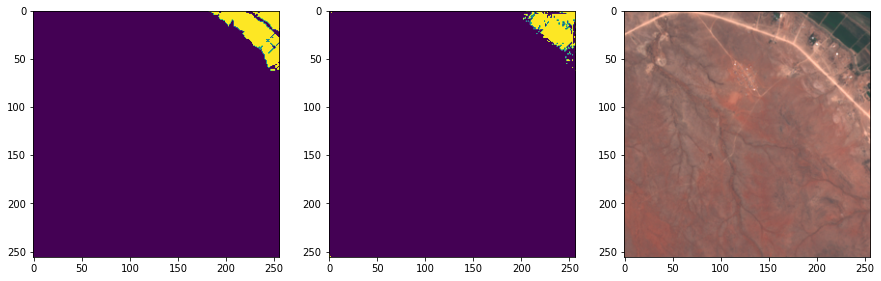

In [47]:
# take some random image from training 
z = X[60].reshape((1,256,256,3))

# predict 
y_pred = model.predict(z)
# binarize prediction
y_pred[y_pred < 0.5] = 0
y_pred[y_pred > 0.5] = 1

# plot the results with matplotlib
f, axarr = plt.subplots(1, 3)
f.set_size_inches(15, 15)
axarr[0].imshow(Y[60].reshape((256,256)))
axarr[1].imshow(y_pred.reshape((256,256)))
axarr[2].imshow(X[60].astype(np.uint8))